In [3]:
%%capture
!pip install keras-tuner --upgrade

In [4]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from math import sqrt
import warnings
import time

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder, MinMaxScaler


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import keras_tuner as kt
from tensorflow import keras

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import pickle
import os
import random


In [ ]:
seed = 115
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
# To print losses
def plots():
    f, ax = plt.subplots(1,1)
    actual_val=np.array(scaler.inverse_transform(valY).reshape(-1,1))
    predicted_val=np.array(scaler.inverse_transform(model.predict(valX).reshape(-1,1)))
    actual_test=np.array(scaler.inverse_transform(testY).reshape(-1,1))
    predicted_test=np.array(scaler.inverse_transform(model.predict(testX).reshape(-1,1)))

    #actual=testY
    #predicted= model.predict(testX)

    actual=np.array(scaler.inverse_transform(np.array(trainY).reshape(-1,1)))
    predicted=np.array(scaler.inverse_transform(model.predict(np.array(trainX)).reshape(-1,1)))

    plt.rcParams["figure.figsize"] = (6,6)
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams["savefig.format"] = 'tiff'

    sns.set(style='whitegrid')
    sns.set_context("paper", font_scale=1.5)

    plt.scatter(actual_test,predicted_test, color='purple', label='Test', linewidths=1, edgecolors='black', s=75)
    sns.regplot(x=actual,y=predicted, color='orangered', label='Train', scatter_kws={'s':40, 'alpha':0.5, 'edgecolor':'black'})
    print("R square (R^2) for train:                 %f" % r2_score(actual,predicted))
    print("R square (R^2) for val:                 %f" % r2_score(actual_val,predicted_val))
    print("Mean absolute error (MAE)- Test:      %f" % mean_absolute_error(actual_test,predicted_test))
    print("Mean squared error (MSE)- Test:       %f" % mean_squared_error(actual_test,predicted_test))
    print("Root mean squared error (RMSE) - Test: %f" % sqrt(mean_squared_error(actual_test,predicted_test)))
    print("R square (R^2) - Test:                 %f" % r2_score(actual_test,predicted_test))


    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    #plt.suptitle("Actual Vs Predicted")
    anchored_text = AnchoredText("R\u00b2 Score_train  "+str(round(r2_score(actual,predicted),3))+'\n'"R\u00b2 Score_test  "+str(round(r2_score(actual_test,predicted_test),3)), loc=2,prop=dict(size=8))
    # anchored_text = AnchoredText("R\u00b2 Score =  "+str(round(r2_score(actual_test,predicted_test),3)), loc=2,prop=dict(size=15))
    ax.add_artist(anchored_text)

    plt.legend(loc = 9, prop={'size': 8}) #labels=["Test","Train"],
    plt.tight_layout()
    plt.savefig(str(model)[1:6], bbox_inches='tight')

In [ ]:
df = pd.read_csv(
    'data.csv'
)

In [ ]:
with open('train_ids', 'rb') as f:
    train_ids = pickle.load(f)

with open('val_ids', 'rb') as f:
    val_ids = pickle.load(f)

with open('test_ids', 'rb') as f:
    test_ids = pickle.load(f)

Train = df[df['Reagent ID Number'].isin(train_ids)]
Non_train = df[~df['Reagent ID Number'].isin(train_ids)]  #Non_train is Validation + Test samples
Val = Non_train.sample(frac=0.5, random_state=42)
Test = Non_train[~Non_train.index.isin(Val.index)]

In [ ]:
# Combine Train and test for feature engineering
DF_raw = pd.concat([Train,Val, Test],ignore_index=True)
DF_data = DF_raw.copy()

In [ ]:
DF_data.shape

(99, 253)

In [ ]:
# Removing Unwanted columns
DF_data=DF_data.drop(['Smiles', 'Reagent ID Number', 'TOR'],axis=1)
DF_data

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,nAromAtom,nSpiro,nBridgehead,nHetero,nN,...,JGI4,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,Lipinski,GhoseFilter,TC+DA
0,15.062188,0,1,2.571754,1.272459,12,0,0,5,0,...,0.050926,0.031949,0.019593,0.005102,0.0,0.0,1.00,0,1,45.5
1,14.464471,0,1,2.570047,1.261124,12,0,0,4,0,...,0.052921,0.035306,0.006944,0.000000,0.0,0.0,0.75,0,1,44.1
2,14.464471,0,1,2.570047,1.261124,12,0,0,5,0,...,0.052921,0.035306,0.006944,0.000000,0.0,0.0,0.75,0,1,42.1
3,14.464471,0,1,2.570047,1.261124,12,0,0,5,0,...,0.052921,0.035306,0.006944,0.000000,0.0,0.0,0.75,0,0,41.0
4,16.891548,0,1,2.579684,1.215807,12,0,0,7,0,...,0.049745,0.035886,0.030315,0.005102,0.0,0.0,1.00,0,0,39.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,15.015593,0,0,2.617560,1.148421,9,0,0,12,2,...,0.064713,0.033476,0.026786,0.000000,0.0,0.0,1.00,1,1,55.1
95,11.009817,0,0,2.487010,1.224249,6,0,0,6,0,...,0.061790,0.040000,0.000000,0.000000,0.0,0.0,1.00,1,0,53.9
96,11.904202,0,0,2.539548,1.188258,6,0,0,5,0,...,0.069286,0.040000,0.000000,0.000000,0.0,0.0,1.00,1,1,79.7
97,12.720699,0,0,2.548650,1.162415,6,0,0,5,0,...,0.082005,0.060612,0.000000,0.000000,0.0,0.0,0.75,1,1,79.8


In [ ]:
DF_data = DF_data[['nBase', 'EState_VSA8', 'ATSC3i', 'AATS0v', 'PEOE_VSA13', 'TC+DA']]

In [ ]:

# Scaling the whole DataFrame

scaler = StandardScaler()
scaled_DF = pd.DataFrame(scaler.fit_transform(DF_data.iloc[:,:-1]))
scaled_DF.columns = DF_data.iloc[:,:-1].columns

scaled_DF['TC+DA'] = scaler.fit_transform(np.array(DF_data['TC+DA']).reshape(-1,1))


display(scaled_DF)

,nBase,EState_VSA8,ATSC3i,AATS0v,PEOE_VSA13,TC+DA
0,0.789272,-0.442679,-0.006569,-0.406489,-0.481007,-0.499611
1,0.789272,-0.442679,-0.402979,-0.335959,-0.481007,-0.595612
2,0.789272,-0.442679,-0.019191,0.451015,-0.481007,-0.732758
3,0.789272,-0.442679,-0.205240,1.023132,-0.481007,-0.808188
4,0.789272,-0.442679,-0.679246,0.348225,-0.481007,-0.931618
...,...,...,...,...,...,...
94,-1.266990,0.274615,1.189372,0.781663,3.410279,0.158687
95,-1.266990,0.141038,0.542582,1.601301,-0.481007,0.076400
96,-1.266990,-0.442679,1.277281,-0.734606,-0.481007,1.845574
97,-1.266990,-0.442679,1.155534,-1.166487,-0.481007,1.852431


In [ ]:
DF_target = scaled_DF[['TC+DA']]
scaled_DF.drop('TC+DA',axis=1,inplace=True)

# display(scaled_DF)
# display(DF_target)

In [ ]:
trainX = scaled_DF.iloc[:77, :]
valX = scaled_DF.iloc[77:88, :]
testX = scaled_DF.iloc[88:,:]

trainY = DF_target.iloc[:77, :]
valY = DF_target.iloc[77:88, :]
testY = DF_target.iloc[88:, :]

In [ ]:
valX.shape

(11, 5)

In [ ]:
# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 160:
        return lr
    else:
        return lr * np.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler)

# Define the model builder for Keras Tuner
def model_builder(hp):
    init = keras.initializers.RandomNormal()
    model = Sequential()

    # Input layer
    model.add(layers.Dense(
        units=hp.Int('units_input', min_value=16, max_value=128, step=16),
        activation='relu',
        kernel_initializer=init,
        input_dim=scaled_DF.shape[1]
    ))
    model.add(layers.Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))

    # Hidden layers
    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_hidden_{i}', min_value=64, max_value=256, step=64),
            activation='relu',
            kernel_initializer=init
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_hidden_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1, kernel_initializer=init, activation='linear'))

    # Optimizer and learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse')
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='my_dir',
    project_name='tuning_neural_network'
)

# Search for the best hyperparameters
tuner.search(
    trainX, trainY,
    epochs=100,
    batch_size=32,
    validation_data=(valX, valY),
    callbacks=[callback]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    trainX, trainY,
    epochs=200,
     batch_size=32,
    validation_data=(valX, valY),
    callbacks=[callback],
    verbose=1
)

# Print the optimal hyperparameters
print("Optimal Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Trial 254 Complete [00h 00m 21s]
val_loss: 0.06213320419192314

Best val_loss So Far: 0.04666800796985626
Total elapsed time: 00h 26m 39s
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.8747 - val_loss: 0.2533 - learning_rate: 0.0100
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2728 - val_loss: 0.3899 - learning_rate: 0.0100
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3337 - val_loss: 0.3424 - learning_rate: 0.0100
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2598 - val_loss: 0.2896 - learning_rate: 0.0100
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2362 - val_loss: 0.1610 - learning_rate: 0.0100
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2137 - val_loss: 0.3538 - learning_rate: 0.0100
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2155 - val_loss: 0.2584 - learning_rate: 0.0100
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1585 - val_loss: 0.0892 - learning_rate: 0.0100
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2743 - val_loss: 0.2350 - learning_rate: 0.0100
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
  if epoch < 160:
    return lr
  else:
    return lr * np.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler)

# Neural Network
def Neural_network():
    # Initialize weights with a random normal initializer
    init = keras.initializers.RandomNormal()
    model = Sequential()

    # Input Layer
    model.add(layers.Dense(
        96,
        activation='relu',
        kernel_initializer=init,
        input_dim=scaled_DF.shape[1]
    ))
    model.add(layers.Dropout(0.2))  # 40% dropout as per optimal parameters

    # Hidden Layer
    model.add(layers.Dense(
        256,
        activation='relu',
        kernel_initializer=init
    ))
    model.add(layers.Dropout(0.1))  # 30% dropout as per optimal parameters
    model.add(layers.Dense(
            128,
            activation='relu',
            kernel_initializer=init
        ))
    model.add(layers.Dropout(0.1))

    # Output Layer
    model.add(layers.Dense(
        1,
        kernel_initializer=init,
        activation='linear'  # Linear activation for regression
    ))

    # Optimizer
    optimize = tf.keras.optimizers.Adam(learning_rate=0.01)  # Optimal learning rate

    # Compile the model
    model.compile(
        optimizer=optimize,
        loss='mse'  # Mean Squared Error for regression tasks
    )
    return model

# Training Function
def training_model(X_train, Y_train, model, X_val, Y_val):
    # Include callbacks: LearningRateScheduler and optional EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        min_delta=0.001,
        restore_best_weights=True
    )

    history = model.fit(
        trainX, trainY,
        epochs=100,
        batch_size=32,
        validation_data=(valX, valY),  # Add validation data
        verbose=1,  # Set verbose to 1 for training logs
        callbacks=[callback, early_stopping]  # Add callbacks
    )
    return history


In [ ]:
model = Neural_network()
# Define Callbacks

history = training_model(trainX, trainY, model, valX, valY)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 0.9016 - val_loss: 0.3408 - learning_rate: 0.0100
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4033 - val_loss: 0.2787 - learning_rate: 0.0100
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2304 - val_loss: 0.3895 - learning_rate: 0.0100
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2320 - val_loss: 0.2161 - learning_rate: 0.0100
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1654 - val_loss: 0.2020 - learning_rate: 0.0100
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1808 - val_loss: 0.1683 - learning_rate: 0.0100
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1473 - val_loss: 0.1998 - learning_rate: 0.0100
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1271 - val_loss: 0.1706 - learning_rate: 0.0100
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1291 - val_loss: 0.1144 - learning_rate: 0.0100
Epoch 10/100
3/3 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R square (R^2) for train:                 0.929759
R square (R^2) for val:                 0.956981
Mean absolute error (MAE)- Test:      3.370809
Mean squared error (MSE)- Test:       13.459909
Root mean squared error (RMSE) - Test: 3.668775
R square (R^2) - Test:                 0.949893


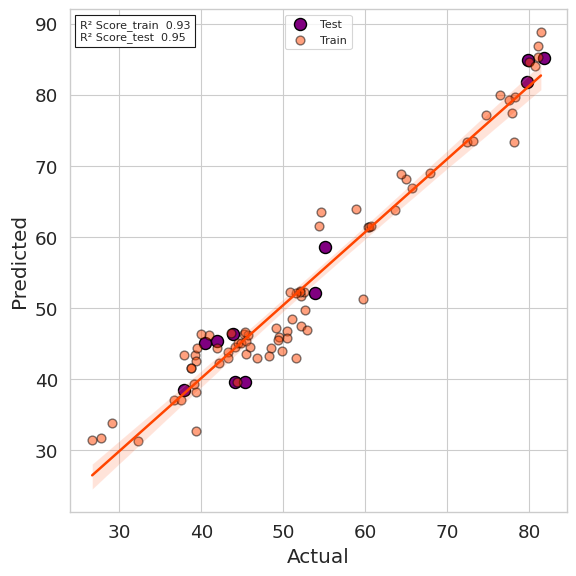

In [ ]:
plots()

In [ ]:
model = load_model('nn_tuned.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R square (R^2) for train:                 0.945470
R square (R^2) for val:                 0.950867
Mean absolute error (MAE)- Test:      3.239277
Mean squared error (MSE)- Test:       11.786454
Root mean squared error (RMSE) - Test: 3.433141
R square (R^2) - Test:                 0.956123


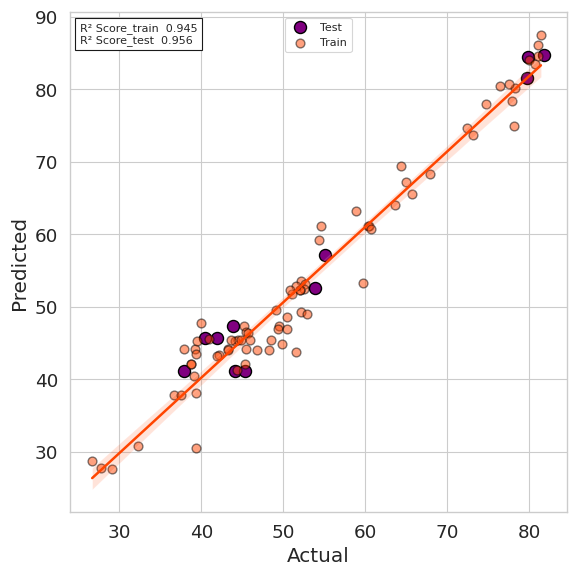

In [ ]:
plots()